# Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import os
from sklearn.model_selection import train_test_split
import shutil
import gc
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

In [ ]:
RANDOM_STATE = 42

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Загрузка данных

In [ ]:
# # colab data unar

# !sudo apt install unar
# !unar 'drive/MyDrive/sorted_data_merged.rar'

# Terminal

## Формирование выборки для обучения


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx][self.target_column]
        img = Image.open(self.data.iloc[idx]['file_name']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
df = pd.read_pickle('drive/MyDrive/df_markup.pkl')
df = df.loc[
    (df['other']==0) & (df['quality_photo']==1),
    ['file_name', 'terminal', 'receipt', 'quality_photo', 'anticlass']
]
df['file_name'] = df['file_name'].apply(lambda x: x.split('..\\data\\')[1].replace('\\', '/'))

In [ ]:
df.shape

(9374, 5)

In [ ]:
from PIL import UnidentifiedImageError
for file in tqdm(df['file_name']):
    try:
        img = Image.open(file)
    except UnidentifiedImageError:
        df = df[df['file_name']!=file]

100%|██████████| 9374/9374 [00:01<00:00, 4756.54it/s]


In [ ]:
df.shape

(8978, 5)

In [ ]:
df_temp = df.copy().sample(10)
df_temp

,file_name,terminal,receipt,quality_photo
8745,sorted_data_merged/undamaged/ЗНО0301444298_TS9...,1,0,1
5548,sorted_data_merged/receipts/ЗНО0301572831_TS90...,0,1,1
9845,sorted_data_merged/undamaged/╨Ч╨Э╨Ю0301666112_...,1,0,1
2148,sorted_data_merged/damaged/ЗНО0301312681_TS903...,1,0,1
7136,sorted_data_merged/receipt_undamaged/ЗНО030139...,1,1,1
881,sorted_data_merged/anticlass_augm/ЗНО030157047...,0,0,1
5621,sorted_data_merged/receipts/ЗНО0301575816_TS90...,0,1,1
1618,sorted_data_merged/anticlass_augm/ЗНО030173012...,0,0,1
5163,sorted_data_merged/receipts/ЗНО0301512018_TS90...,0,1,1
7652,sorted_data_merged/terminal/ЗНО0301422230_TS90...,1,0,1


terminal:	1
receipt:	0


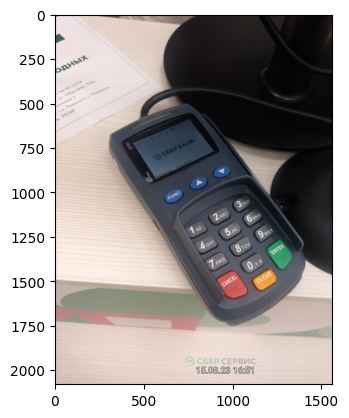

terminal:	0
receipt:	1


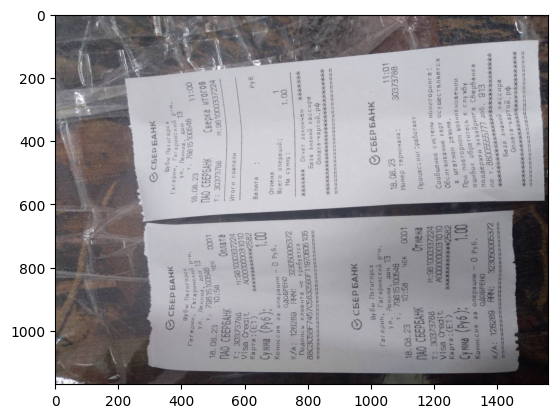

terminal:	1
receipt:	0


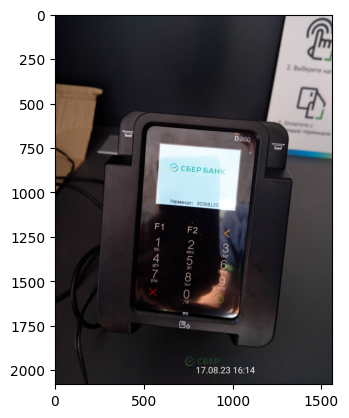

terminal:	1
receipt:	0


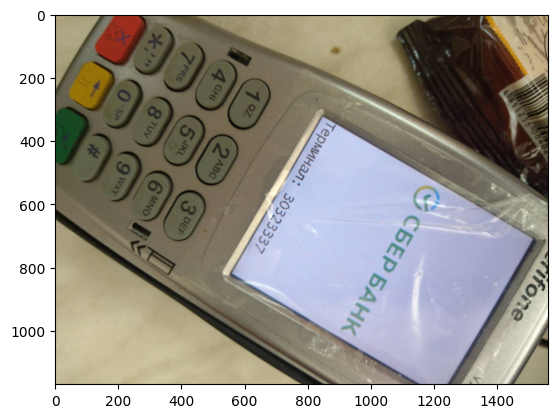

terminal:	1
receipt:	1


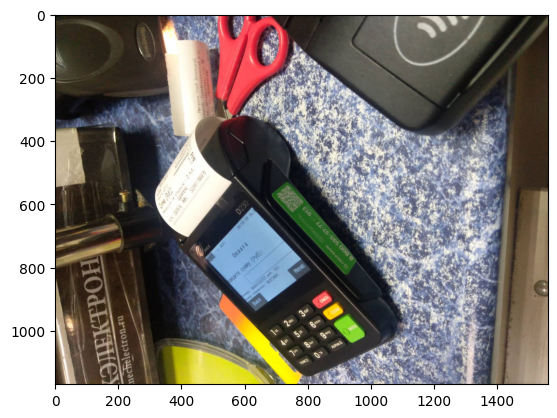

terminal:	0
receipt:	0


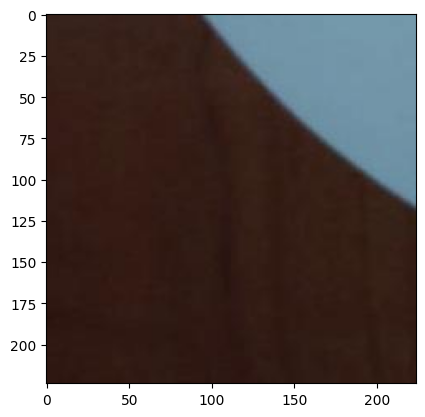

terminal:	0
receipt:	1


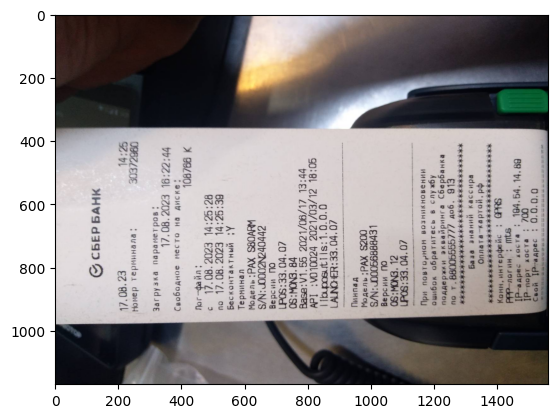

terminal:	0
receipt:	0


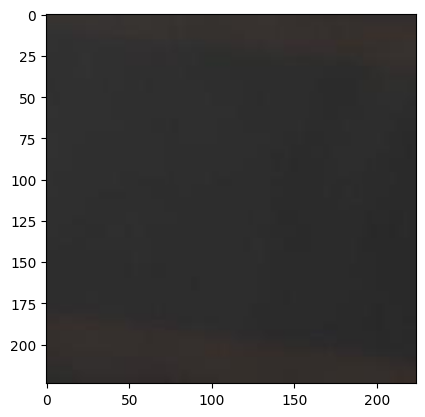

terminal:	0
receipt:	1


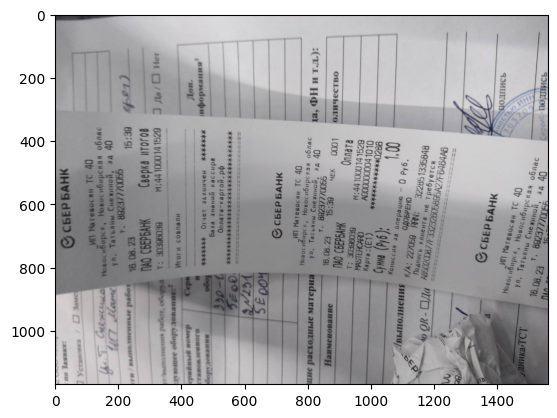

terminal:	1
receipt:	0


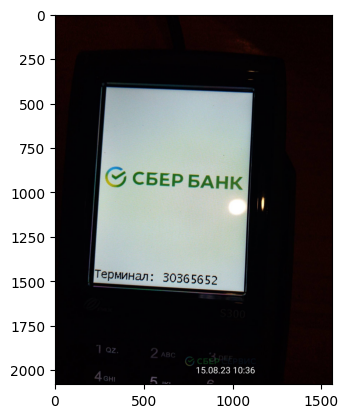

In [ ]:
for row in df_temp.iterrows():
    row = row[1]
    img = Image.open(row['file_name'])
    print(f'terminal:\t{row["terminal"]}\nreceipt:\t{row["receipt"]}')
    plt.imshow(img)
    plt.show()

In [ ]:
df_terminal = df.drop(columns=['receipt'])
train_terminal, test_terminal = train_test_split(
    df_terminal, stratify=df_terminal['terminal'], test_size=0.25, random_state=RANDOM_STATE
)

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_terminal_dataset = CustomDataset(train_terminal, target_column='terminal', transform=train_transforms)
train_terminal_dataloader = DataLoader(train_terminal_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_terminal_dataset = CustomDataset(test_terminal, target_column='terminal', transform=test_transforms)
test_terminal_dataloader = DataLoader(test_terminal_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    axs[2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test')
    axs[2].set_ylabel('F1')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, f1_score_value = 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        f1_score_value += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    f1_score_value /= len(train_loader)

    return train_loss, train_accuracy, f1_score_value


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1 = 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)

    return test_loss, test_accuracy, test_f1


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s = [], [], []
    test_losses, test_accuracies, test_f1s = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1 = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s)

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
num_epochs = 10

model_terminal = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
# Заменяем исходную голову модели на голову с правильным числом классов
model_terminal.classifier[1] = torch.nn.Linear(1280, 2)
model_terminal = model_terminal.to(device)
optimizer = torch.optim.SGD(model_terminal.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 38.1MB/s]


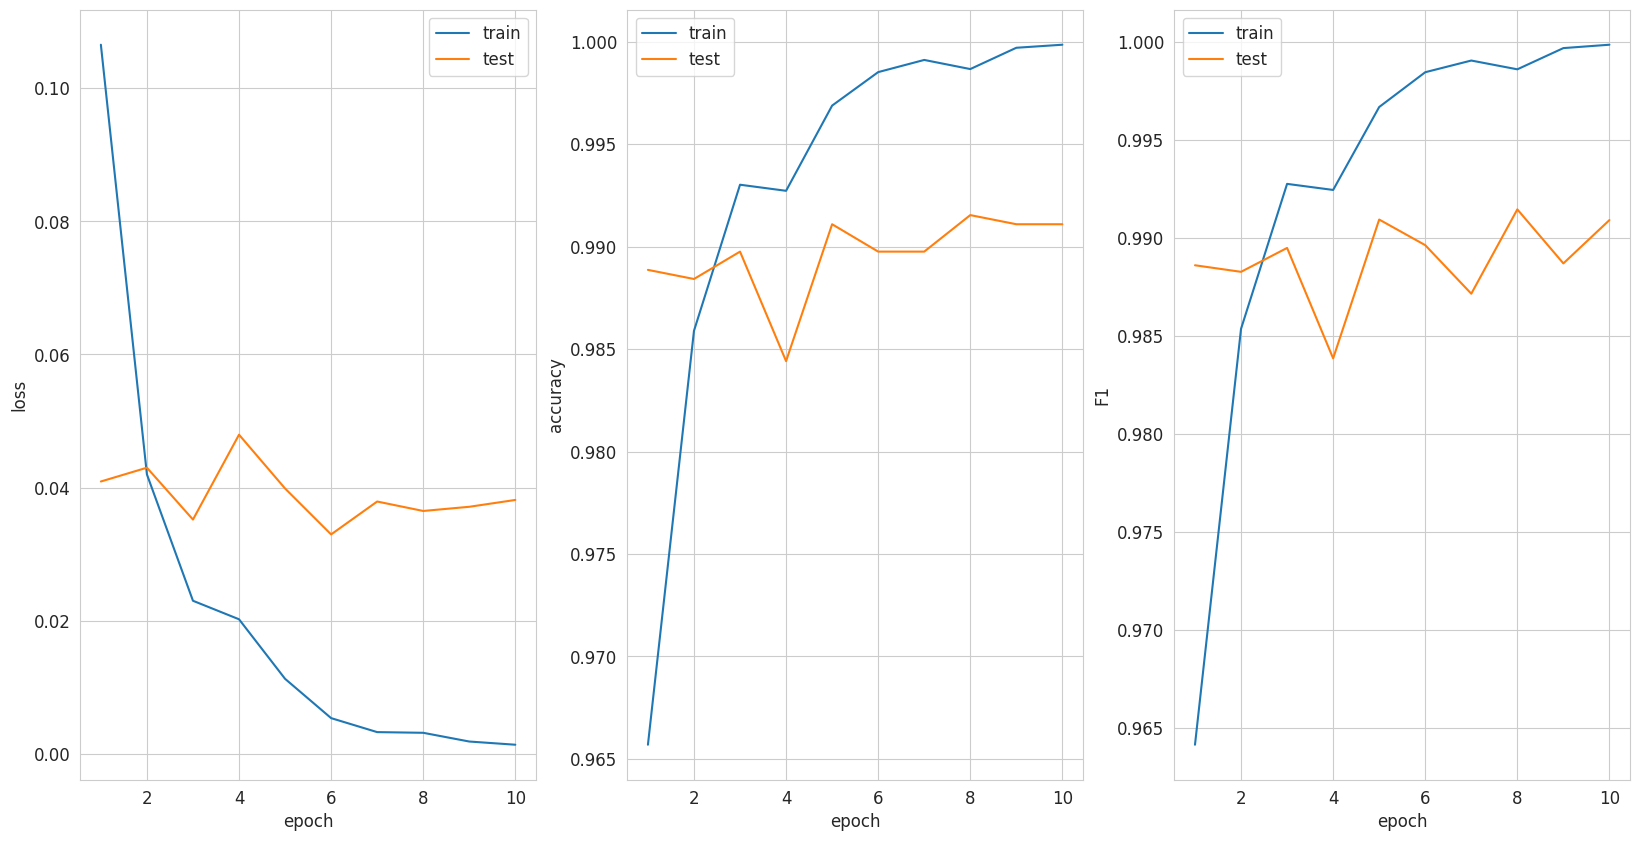

In [ ]:
gc.collect()
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model_terminal, optimizer, scheduler, criterion, train_terminal_dataloader, test_terminal_dataloader, num_epochs
)

In [ ]:
model_scripted_terminal = torch.jit.script(model_terminal) # Export to TorchScript
model_scripted_terminal.save('models/model_terminal.pt') # Save

# Чеки

In [ ]:
df.head()

,file_name,terminal,receipt,quality_photo,anticlass
0,sorted_data_merged/anticlass/ЗНО0301278484_TS9...,0,0,1,1
1,sorted_data_merged/anticlass/ЗНО0301278522_TS9...,0,0,1,1
2,sorted_data_merged/anticlass/ЗНО0301279003_TS9...,0,0,1,1
3,sorted_data_merged/anticlass/ЗНО0301283191_TS9...,0,0,1,1
4,sorted_data_merged/anticlass/ЗНО0301285365_TS9...,0,0,1,1


In [ ]:
df_receipt = df.drop(columns=['terminal', 'quality_photo'])
train_receipt, test_receipt = train_test_split(
    df_receipt, stratify=df_receipt['receipt'], test_size=0.25, random_state=RANDOM_STATE
)

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_receipt_dataset = CustomDataset(train_receipt, target_column='receipt', transform=train_transforms)
train_receipt_dataloader = DataLoader(train_receipt_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_receipt_dataset = CustomDataset(test_receipt, target_column='receipt', transform=test_transforms)
test_receipt_dataloader = DataLoader(test_receipt_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
num_epochs = 10

model_receipt = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
# Заменяем исходную голову модели на голову с правильным числом классов
model_receipt.classifier[1] = torch.nn.Linear(1280, 2)
model_receipt = model_receipt.to(device)
optimizer = torch.optim.SGD(model_receipt.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

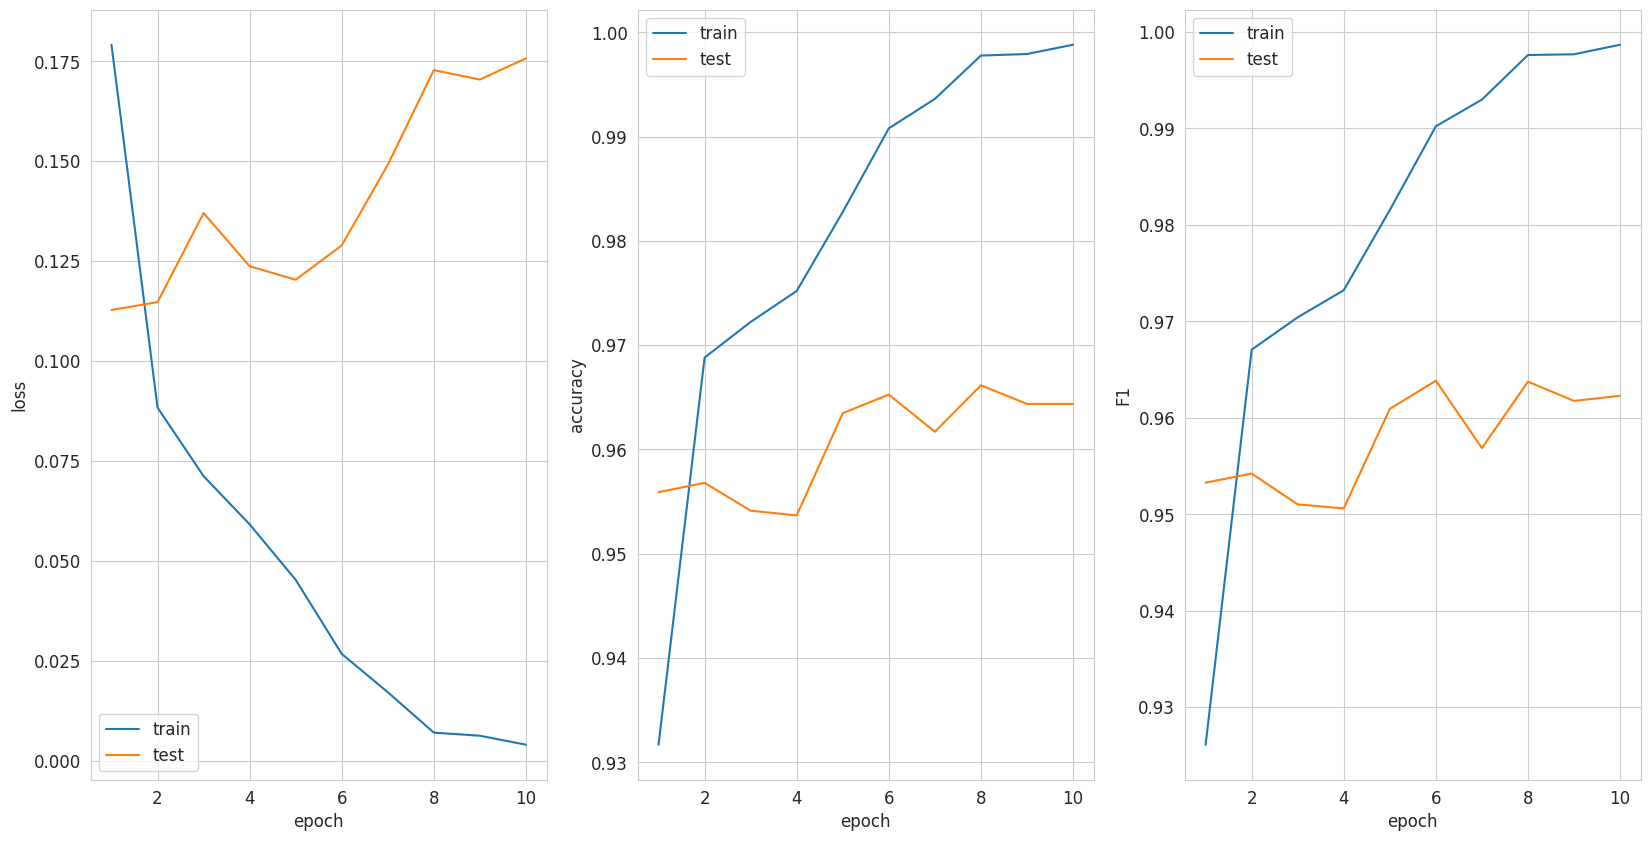

In [ ]:
gc.collect()
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model_receipt, optimizer, scheduler, criterion, train_receipt_dataloader, test_receipt_dataloader, num_epochs
)

In [ ]:
model_scripted_receipt = torch.jit.script(model_receipt) # Export to TorchScript
model_scripted_receipt.save('models/model_receipt.pt') # Save

# Валидация

In [ ]:
test_file_names = list(set(test_terminal['file_name']) & set(test_receipt['file_name']))
print(f'Количество файлов для теста:\t{len(test_file_names)}')
df_test = test_terminal[test_terminal['file_name'].isin(test_file_names)].copy()
df_test = df_test.merge(test_receipt, how='left').drop(columns=['quality_photo'])
# df_test['file_name'] = df_test['file_name'].apply(lambda x: ('../../data/'+x).replace('/', '\\'))

Количество файлов для теста:	790


In [ ]:
df_test['value'] = ''
df_test.loc[
    (df_test['terminal']==0) &
    (df_test['receipt']==1),
    'value'
] = 'receipt'
df_test.loc[
    (df_test['terminal']==1) &
    (df_test['receipt']==0),
    'value'
] = 'terminal'
df_test.loc[
    (df_test['terminal']==1) &
    (df_test['receipt']==1),
    'value'
] = 'receipt_terminal'
df_test.loc[
    (df_test['terminal']==0) &
    (df_test['receipt']==0),
    'value'
] = 'nothing'
df_test['value'].value_counts()

nothing             305
terminal            252
receipt             194
receipt_terminal     39
Name: value, dtype: int64

In [ ]:
model_scripted_receipt = torch.jit.load('model_receipt.pt', map_location=device)
model_scripted_receipt.eval()
clear_output()
model_scripted_terminal = torch.jit.load('model_terminal.pt', map_location=device)
model_scripted_terminal.eval()
clear_output()

In [ ]:
# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 4
test_dataset = CustomDataset(df_test, target_column='value', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
all_labels, all_preds_terminal, all_preds_receipt = [], [], []
for images, labels in tqdm(test_dataloader):
    images = images.to(device)  # images: batch_size x num_channels x height x width

    logits_terminal = model_scripted_terminal(images)  # logits: batch_size x num_classes
    predictions_terminal = logits_terminal.argmax(dim=1)

    logits_receipt = model_scripted_receipt(images)  # logits: batch_size x num_classes
    predictions_receipt = logits_receipt.argmax(dim=1)

    all_labels.append(labels)
    all_preds_terminal.append(predictions_terminal)
    all_preds_receipt.append(predictions_receipt)

100%|██████████| 198/198 [00:23<00:00,  8.35it/s]


In [ ]:
all_preds_terminal = [torch.Tensor.cpu(x).numpy() for x in all_preds_terminal]
all_preds_receipt = [torch.Tensor.cpu(x).numpy() for x in all_preds_receipt]

In [ ]:
df_val = pd.DataFrame({
    'labels': np.hstack(all_labels),
    'predictions_terminal': np.hstack(all_preds_terminal),
    'predictions_receipt': np.hstack(all_preds_receipt)
})
df_val.head()

,labels,predictions_terminal,predictions_receipt
0,receipt,0,1
1,receipt,0,1
2,receipt,0,1
3,receipt,0,1
4,nothing,0,0


In [ ]:
df_val['prediction'] = ''
df_val.loc[
    df_val['predictions_terminal']==1,
    'prediction'
] = 'terminal'
df_val.loc[
    df_val['predictions_receipt']==1,
    'prediction'
] = 'receipt'
df_val.loc[
    (df_val['predictions_receipt']==1) &
    (df_val['predictions_terminal']==1),
    'prediction'
] = 'receipt_terminal'
df_val.loc[
    (df_val['predictions_receipt']==0) &
    (df_val['predictions_terminal']==0),
    'prediction'
] = 'nothing'

In [ ]:
df_val['prediction'].value_counts()

nothing             303
terminal            258
receipt             191
receipt_terminal     38
Name: prediction, dtype: int64

In [ ]:
df_val['labels'].unique()

array(['receipt', 'nothing', 'terminal', 'receipt_terminal'], dtype=object)

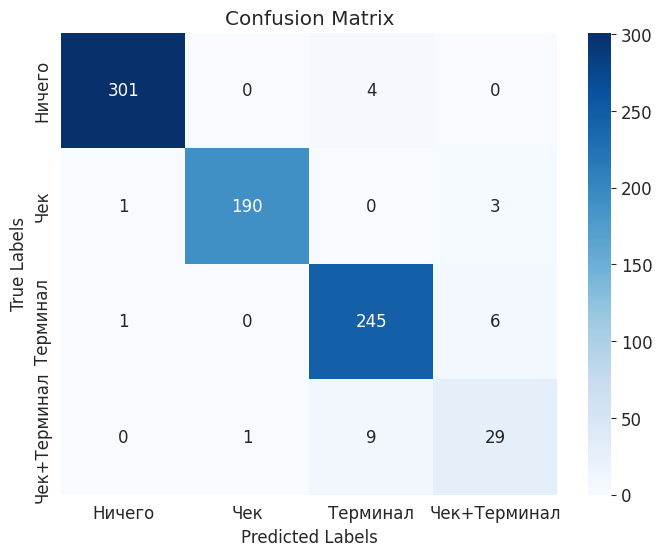

In [ ]:
from sklearn.metrics import confusion_matrix

df_val = df_val[['labels', 'prediction']]
cm = confusion_matrix(df_val['labels'], df_val['prediction'], labels=['nothing', 'receipt', 'terminal', 'receipt_terminal'])

# Define class labels
class_names = ['Чек+Терминал', 'Чек', 'Терминал'] # df_val['labels'].unique()
class_names = ['Ничего', 'Чек', 'Терминал', 'Чек+Терминал']
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()